In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/182/procgen/christian

/gdrive/MyDrive/182/procgen/christian


In [3]:
ls

Analysis2.ipynb      load_templates.py           test.py
Analysis.ipynb       logs/                       train_colab.ipynb
CustomCNNPolicy.py   old_scripts/                train_colab.py
FeatureExtractor.py  __pycache__/                train_new.py
GymDebug.ipynb       template_match_demo.py      train_procgen_pfrl/
images/              TemplateMatchingDemo.ipynb  train.py


In [4]:
! cp -a ../adam/template_match_demo.py .

In [5]:
! cp -a ../adam/load_templates.py .

In [4]:
! pip install procgen

     |████████████████████████████████| 39.9MB 1.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 3.3MB 42.5MB/s 
     |████████████████████████████████| 675kB 37.8MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 204kB 41.4MB/s 
     |████████████████████████████████| 40kB 5.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [5]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
import cv2
import os
from scipy import signal
import numpy as np

def set_template_scores(templates):
    """set metadata or scores for templates, appropriately"""
    for k, v in templates.items():
        v["fruit"] = "fruit" in k #fruit increases score
        v["food"] = "food" in k #food decreases score
        
    return templates

def load_templates():

    #downsample factor
    # fact = 4
    # target_height = 5
    target_width = 7
    fig, ax = plt.subplots(
        len(os.listdir('images')) - 1, 2, figsize=(20, 20))
    templates = {}

    image_list = os.listdir("images")
    image_list = [i for i in image_list if '.png' in i]
    for i, f in enumerate(image_list):
        if 'renders' in f:
          continue

        img = cv2.imread(os.path.join("images", f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        templates[f] = {}

        if 'robot' in f:
            img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        # fact = img.shape[0] / target_height
        fact = img.shape[1] / target_width

        templates[f]['orig'] = img

        templates[f]['img'] = cv2.resize(
            img, 
            (int(img.shape[1] / fact), int(img.shape[0] / fact)), 
            interpolation=cv2.INTER_CUBIC).astype(np.float32)

        templates[f]['ds-img'] = cv2.resize(
            img, 
            (int(img.shape[1] / fact), int(img.shape[0] / fact)), 
            interpolation=cv2.INTER_CUBIC)
        
        tmp_mat = np.zeros((7, 7, 3))
        tmp_mat2 = np.zeros((7, 7, 3))
        h, w, c = templates[f]['img'].shape

        if h > 7:
            psh, peh = 0, 7
            ish = int(np.floor((h - 7) * 0.5))
            ieh = ish + 7
        else:
            psh = int(np.ceil((7 - h) * 0.5))
            peh = psh + h
            ish, ieh = 0, h


        tmp_mat[psh:peh, :, :] += templates[f]['img'][ish:ieh, :, :]
        tmp_mat2[psh:peh, :, :] += templates[f]['ds-img'][ish:ieh, :, :]

        templates[f]['ds-img'] = tmp_mat2.astype(np.int32)
        templates[f]['img'] = tmp_mat

        # templates[f]['img'] = img.astype(np.float32)
        # templates[f]['ds-img'] = img

        #normalize by filter size and values
        templates[f]['img'] = templates[f]['img'] / (
            np.mean(templates[f]['img']) *\
            templates[f]['img'].shape[0] *\
            templates[f]['img'].shape[1])

        #zero-mean the filter
        templates[f]['img'] -= np.mean(templates[f]['img']) 

        # if "food" in f:
        #     print("File Name:", f)
        #     # print(templates[f]['img'])
        #     print("Original Img Shape:", templates[f]['orig'].shape)
        #     print("Processed Img Shape:", templates[f]['img'].shape)
        #     # print(np.mean(templates[f]['img']))

        ax[i, 0].title.set_text(f)
        ax[i, 0].imshow(templates[f]['orig'])
        ax[i, 1].title.set_text(templates[f]['ds-img'].shape)
        ax[i, 1].imshow(templates[f]['ds-img'])
        # print(img.shape)
    
    fig.tight_layout()
    plt.show()
    templates = set_template_scores(templates)
    return templates

In [119]:
import gym3
from procgen import ProcgenGym3Env
import numpy as np
import cv2
import torch
from torch.nn import functional as F

RENDER = True

def template_match(obs, templates):
    """template match against RGB window, observation of shape (nxmx3)"""

    rgb = obs
    bgr = obs
    # bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR) #convert rgb to bgr
    # print(bgr.dtype)

    names = []
    filter_out = np.zeros((
        len(list(templates.keys())), bgr.shape[0], bgr.shape[1]))

    idx = 0
    for k, v in templates.items():
        names.append(k)
        kernel = v['img']
        dst = np.zeros((bgr.shape[0], bgr.shape[1]))
        for i in range(3):
            a = cv2.filter2D(bgr[:,:,i], -1, kernel[:,:,i])
            dst += a
        filter_out[idx] = dst
        idx += 1

    filter_out_orig = filter_out
    filter_out = filter_out.transpose((1, 2, 0))
    filter_out_max = np.max(filter_out, axis=-1)
    filter_out_amax = np.argmax(filter_out, axis=-1)

    # print(filter_out.shape)
    # print(filter_out_max.shape)
    # print(filter_out_amax.shape)

    # print(filter_out_max[:5,:5])
    # print(filter_out_amax[:5,:5])
        
    return filter_out_orig, filter_out_amax, names

In [120]:
import torch

c = torch.nn.Conv2d(
    in_channels=3, out_channels=20, kernel_size=7
)

In [121]:
c.weight.shape

torch.Size([20, 3, 7, 7])

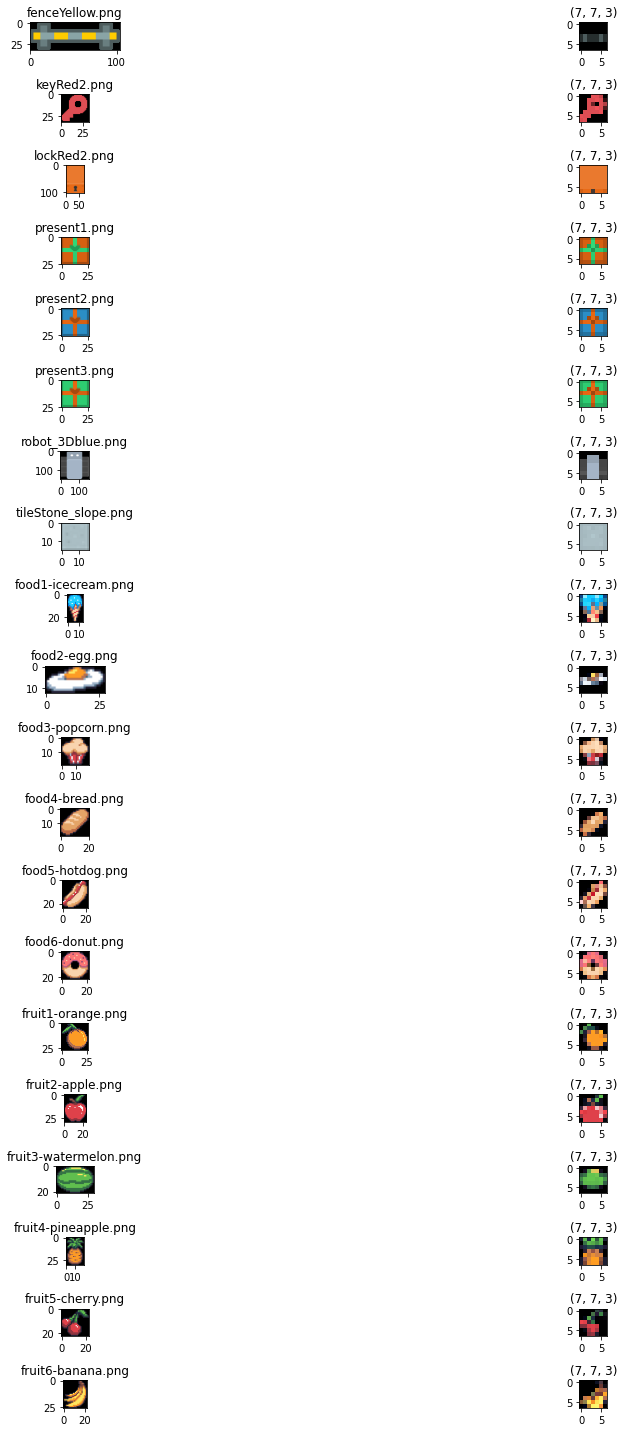

In [122]:
templates = load_templates()

In [57]:
from time import time
from tqdm import tqdm

env = ProcgenGym3Env(
    num=1, distribution_mode='easy', 
    env_name="fruitbot", render_mode="rgb_array")

with tqdm(range(100)) as trange:
    for step in trange:
        env.act(gym3.types_np.sample(env.ac_space, bshape=(env.num,)))
        rew, obs, first = env.observe()

        np.save( f'images/renders/image_{step}', obs['rgb'][0])

        t1 = time()
        filters, locs, names = template_match(obs['rgb'][0], templates)
        # filters, names = # template_match(obs['rgb'][0], templates)
        # filters_shape = filters.shape
        # t2 = time()
        
        # # print(f"step {step} reward {rew} first {first}")
        # step += 1
        # trange.set_description(f"FPS: {1 / (t2 - t1):.3f}. FShape: {filters.shape}. Obs Shape: {obs['rgb'][0].shape}")

        # if step % 10 == 0:
        #     fig, ax = plt.subplots(3, 7, figsize=(15, 15))
        #     # fig, ax = plt.subplots(1, 3, figsize=(15, 15))
        #     display.clear_output(wait=True)

        #     # ax[0].imshow(env.get_info()[0]['rgb'])
        #     ax[0, 0].imshow(env.get_info()[0]['rgb'])
        #     for i, name in enumerate(names):
        #         i += 1
        #         ax[i // 7, i % 7].title.set_text(name)
        #         ax[i // 7, i % 7].imshow(filters[i - 1])

        #     # resize_fact = 8

        #     ax[-1, -1].imshow(obs['rgb'][0])
        #     # ax[-1].imshow(locs)
        #     # ax[-2].imshow(obs['rgb'][0])
        #     # ax[-1].imshow(cv2.resize(
        #     #     env.get_info()[0]['rgb'],
        #     #     (64, 64),
        #     #     interpolation=cv2.INTER_CUBIC
        #     # ))
        #     fig.tight_layout()

        #     display.display(fig)

KeyboardInterrupt: ignored

In [22]:
import torch
random_input = torch.rand(64, 3, 64, 64) #NCHW

In [25]:
custom_kernel = torch.from_numpy(templates['food1-icecream.png']['ds-img']).permute(2, 0, 1) #CHW
custom_kernel = custom_kernel.unsqueeze(0).float()
custom_kernel.shape

torch.Size([1, 3, 5, 2])

In [52]:
from torch.nn import functional as F
from time import time

d = torch.device('cuda')

t1 = time()
batch, _, _, _ = random_input.shape
dst = torch.zeros(batch, len(templates), 64, 64).to(d)
out_dict = {}
random_input = random_input.to(d)
for i, (k, v) in enumerate(templates.items()):
  custom_kernel = v['ds-img']
  custom_kernel = torch.from_numpy(custom_kernel).to(d)
  custom_kernel = custom_kernel.permute(2, 0, 1).unsqueeze(0).float()
  pad = (
      int(np.ceil(0.5 * (custom_kernel.shape[-2] - 1))),
      int(np.ceil(0.5 * (custom_kernel.shape[-1] - 1)))
  )
  out = F.conv2d(random_input, custom_kernel, padding=pad).squeeze(1)
  out_dict[k] = {
      'out': out, 'custom_kernel': custom_kernel
  }
  dst[:, i, :min(64, out.shape[-2]), :min(64, out.shape[-1])] =\
      out[:, :min(64, out.shape[-2]), :min(64, out.shape[-1])]
t2 = time()
1 / (t2 - t1)

44.612187157641706

In [221]:
# out.shape

In [53]:
[[k, v['out'].shape, v['custom_kernel'].shape] for k,v in out_dict.items()]

[['fenceYellow.png', torch.Size([64, 65, 64]), torch.Size([1, 3, 2, 7])],
 ['keyRed2.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['lockRed2.png', torch.Size([64, 65, 64]), torch.Size([1, 3, 10, 7])],
 ['present1.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['present2.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['present3.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['robot_3Dblue.png', torch.Size([64, 65, 64]), torch.Size([1, 3, 6, 7])],
 ['tileStone_slope.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['food1-icecream.png', torch.Size([64, 65, 64]), torch.Size([1, 3, 12, 7])],
 ['food2-egg.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 3, 7])],
 ['food3-popcorn.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['food4-bread.png', torch.Size([64, 65, 64]), torch.Size([1, 3, 6, 7])],
 ['food5-hotdog.png', torch.Size([64, 64, 64]), torch.Size([1, 3, 7, 7])],
 ['food6-donut.png', torch.Size([64, 64, 64

In [235]:
dst.shape

torch.Size([1, 20, 64, 64])

In [139]:
out2 = F.max_pool2d(dst, (8, 8))
out3 = torch.flatten(out2, start_dim=2, end_dim=3)
out4, _ = torch.max(out3, dim=-1)
out5 = 1 * (out3 == out4.unsqueeze(-1))
out6 = torch.flatten(out5, start_dim=1)
out6.shape

torch.Size([1, 1280])

In [13]:
! pip install pfrl

     |████████████████████████████████| 112kB 5.4MB/s 
  Created wheel for pfrl: filename=pfrl-0.2.1-cp37-none-any.whl size=153478 sha256=6633894ff3754362d1c0b1764f8686f7d6565bb90f49157ac4c1f66c1217a9fa
  Stored in directory: /root/.cache/pip/wheels/10/22/cf/8da3465e0b3f7a915241dd5edd3d5d684ac62fb2ec57c25316
Successfully built pfrl


In [14]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=channels,
                               out_channels=channels,
                               kernel_size=3,
                               padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels,
                               out_channels=channels,
                               kernel_size=3,
                               padding=1)

    def forward(self, x):
        inputs = x
        x = torch.relu(x)
        x = self.conv0(x)
        x = torch.relu(x)
        x = self.conv1(x)
        return x + inputs


class ConvSequence(nn.Module):

    def __init__(self, input_shape, out_channels):
        super(ConvSequence, self).__init__()
        self._input_shape = input_shape
        self._out_channels = out_channels
        self.conv = nn.Conv2d(in_channels=self._input_shape[0],
                              out_channels=self._out_channels,
                              kernel_size=3,
                              padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=3,
                                       stride=2,
                                       padding=1)
        self.res_block0 = ResidualBlock(self._out_channels)
        self.res_block1 = ResidualBlock(self._out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.max_pool2d(x)
        x = self.res_block0(x)
        x = self.res_block1(x)
        return x

    def get_output_shape(self):
        _c, h, w = self._input_shape
        return self._out_channels, (h + 1) // 2, (w + 1) // 2

class ImpalaCNN_TMP(nn.Module):
    """Network from IMPALA paper, to work with pfrl."""

    def __init__(self, obs_space, num_outputs):

        super(ImpalaCNN_TMP, self).__init__()

        h, w, c = obs_space.shape
        shape = (c, h, w)

        conv_seqs = []
        for out_channels in [16, 32, 32]:
            conv_seq = ConvSequence(shape, out_channels)
            shape = conv_seq.get_output_shape()
            conv_seqs.append(conv_seq)
        self.conv_seqs = nn.ModuleList(conv_seqs)
        self.hidden_fc = nn.Linear(in_features=shape[0] * shape[1] * shape[2],
                                   out_features=256)
        self.logits_fc = nn.Linear(in_features=256, out_features=num_outputs)
        self.value_fc = nn.Linear(in_features=256, out_features=1)
        # Initialize weights of logits_fc
        nn.init.orthogonal_(self.logits_fc.weight, gain=0.01)
        nn.init.zeros_(self.logits_fc.bias)

    def template_match_torch(random_input, templates, d=torch.device('cuda')):

        random_input = torch.from_numpy(random_input).float().to(d)
        dst = torch.zeros(1, len(templates), 64, 64).to(d)
        names = []
        random_input = random_input.to(d)
        for i, (k, v) in enumerate(templates.items()):
            custom_kernel = v['ds-img']
            custom_kernel = torch.from_numpy(custom_kernel).to(d)
            custom_kernel = custom_kernel.permute(2, 0, 1).unsqueeze(0).float()
            out = F.conv2d(random_input, custom_kernel, padding=(3, 3)).squeeze()

            dst[0, i, :min(64, out.shape[0]), :min(64, out.shape[1])] =\
                out[:min(64, out.shape[0]), :min(64, out.shape[1])]
            names.append(k)

        out2 = F.max_pool2d(dst, (8, 8))
        out3 = torch.flatten(out2, start_dim=2, end_dim=3)
        out4, _ = torch.max(out3, dim=-1)
        out5 = 1 * (out3 == out4.unsqueeze(-1))
        out6 = torch.flatten(out5, start_dim=1)

        # dst = dst.squeeze(0)
        out5 = out5.reshape((1, 20, 8, 8)).squeeze(0)
        return out5.detach().cpu().numpy(), out6.detach().cpu().numpy(), names

    def forward(self, obs):
        assert obs.ndim == 4,  f'Invalid Shape: {obs.shape}'
        x = obs / 255.0  # scale to 0-1
        x = x.permute(0, 3, 1, 2)  # NHWC => NCHW
        for conv_seq in self.conv_seqs:
            x = conv_seq(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(x)
        x = self.hidden_fc(x)
        x = torch.relu(x)
        logits = self.logits_fc(x)
        dist = torch.distributions.Categorical(logits=logits)
        value = self.value_fc(x)
        return dist, value

    def save_to_file(self, model_path):
        torch.save(self.state_dict(), model_path)

    def load_from_file(self, model_path):
        self.load_state_dict(torch.load(model_path))

In [15]:
from procgen import ProcgenEnv

env = ProcgenEnv(
    num_envs=1, distribution_mode='easy', 
    env_name="fruitbot")

env.observation_space['rgb'], env.action_space.n

(Box(0, 255, (64, 64, 3), uint8), 15)

In [16]:
m = ImpalaCNN_TMP(
    obs_space=env.observation_space['rgb'],
    num_outputs=env.action_space.n
)

In [182]:
custom_conv = torch.nn.Conv2d(
    in_channels=3, out_channels=20, kernel_size=7,
    padding=int((7 - 1) * 0.5),
    bias=None
).requires_grad_(False)

In [183]:
names = []
custom_weight = []
for k, v in templates.items():
    names.append(k)
    custom_weight.append(v['img'].transpose(2, 0, 1))
custom_weight = np.array(custom_weight)
custom_weight = torch.from_numpy(custom_weight)
custom_weight.shape

torch.Size([20, 3, 7, 7])

In [184]:
custom_conv.bias == None

True

In [185]:
custom_conv.weight.shape

torch.Size([20, 3, 7, 7])

In [186]:
custom_conv.weight.data = custom_weight.float()

In [187]:
def template_match_torch(random_input, templates, custom_conv, d=torch.device('cuda')):
    # Normalize input
    random_input = random_input / (
        np.mean(random_input) *\
        random_input.shape[0] *\
        random_input.shape[1])
    random_input -= np.mean(random_input)
    random_input = torch.from_numpy(random_input).float().to(d)

    random_input = random_input.to(d)
    custom_conv = custom_conv.to(d)
    with torch.no_grad():
        dst = custom_conv(random_input)

    out2 = F.max_pool2d(dst, (2, 2))
    out3 = torch.flatten(out2, start_dim=2, end_dim=3)
    out4, _ = torch.max(out3, dim=-1)
    out5 = 1 * (out3 == out4.unsqueeze(-1))
    out6 = torch.flatten(out5, start_dim=1)

    # dst = dst.squeeze(0)
    out2 = out2.squeeze(0)
    return out2.detach().cpu().numpy(), out6.detach().cpu().numpy()

FPS: 774.376.FShape: (20, 32, 32). Obs Shape: (64, 64, 3):   1%|▏         | 67/5000 [00:20<24:47,  3.32it/s]


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0ae3002e60> (for post_execute):


KeyboardInterrupt: ignored

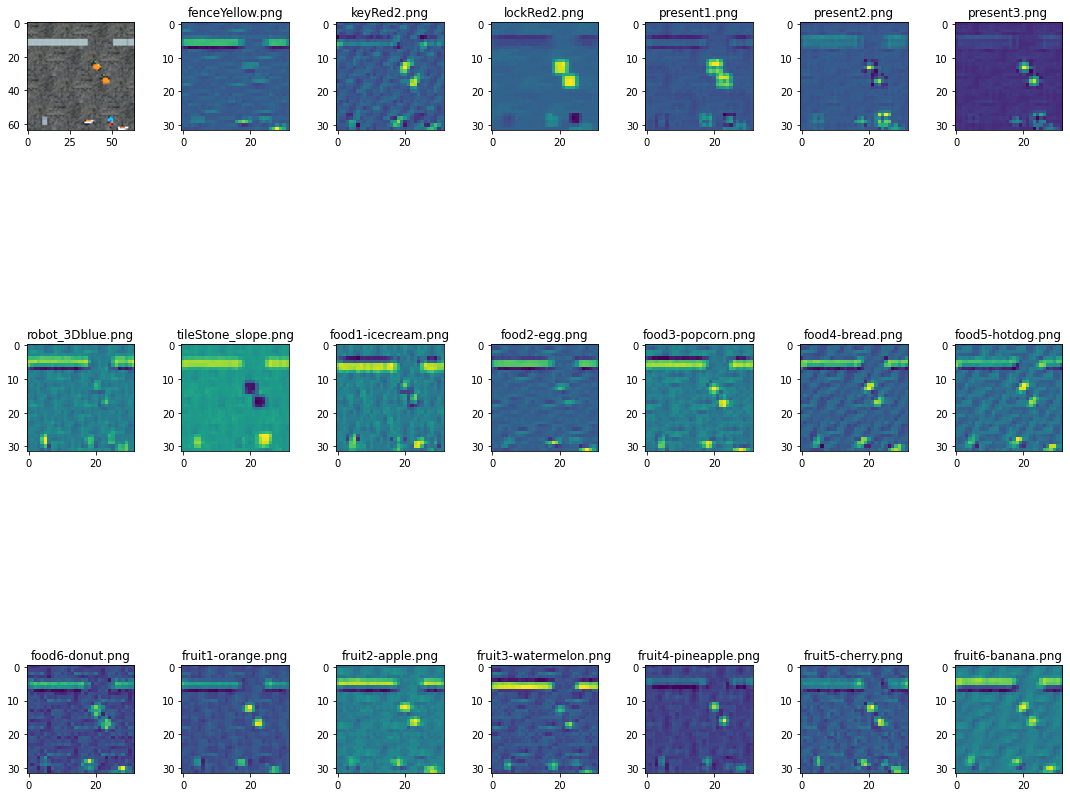

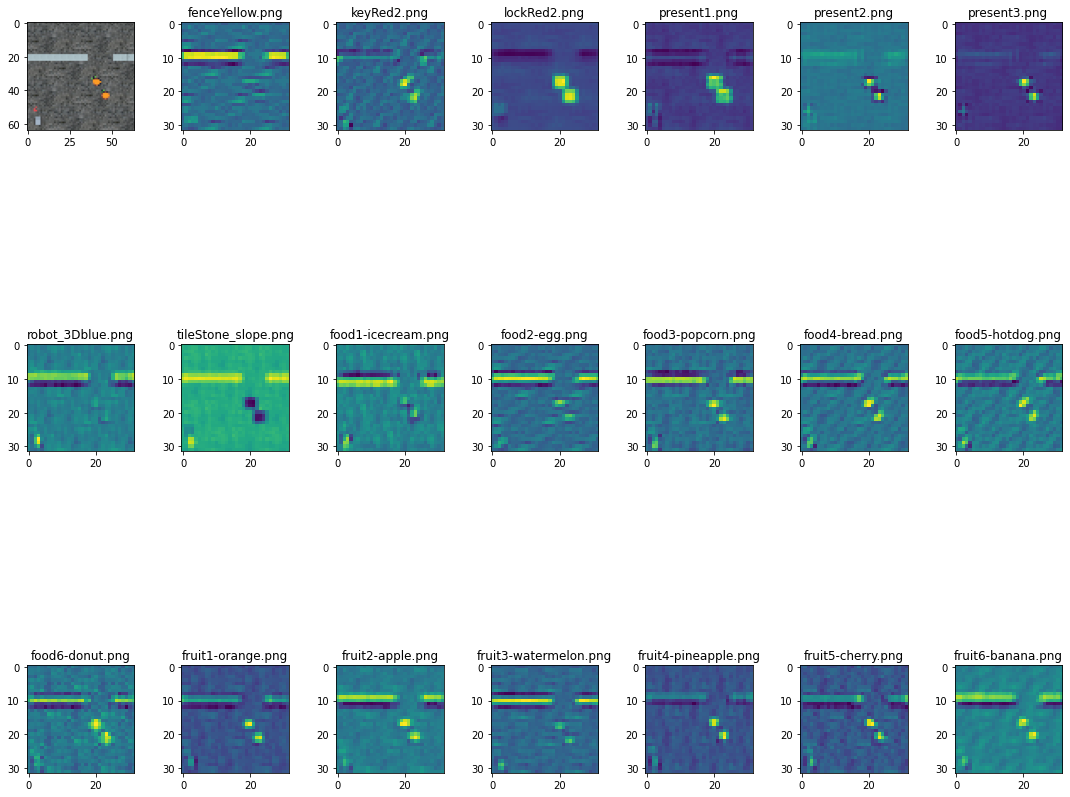

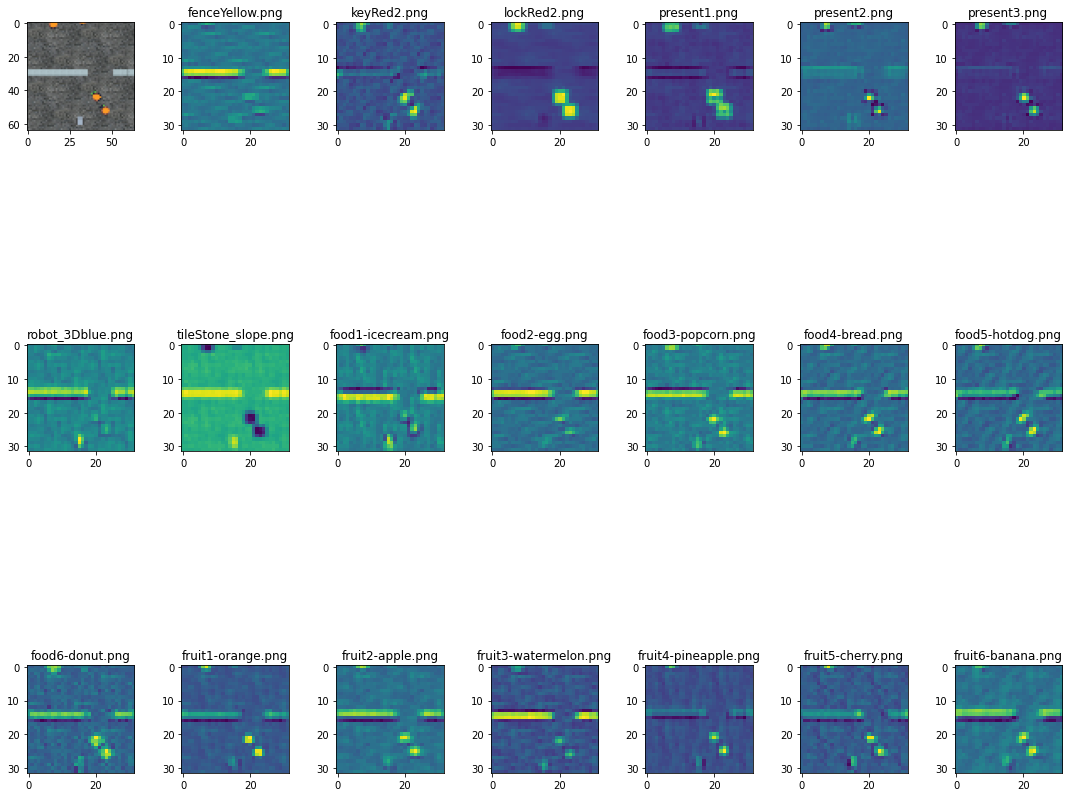

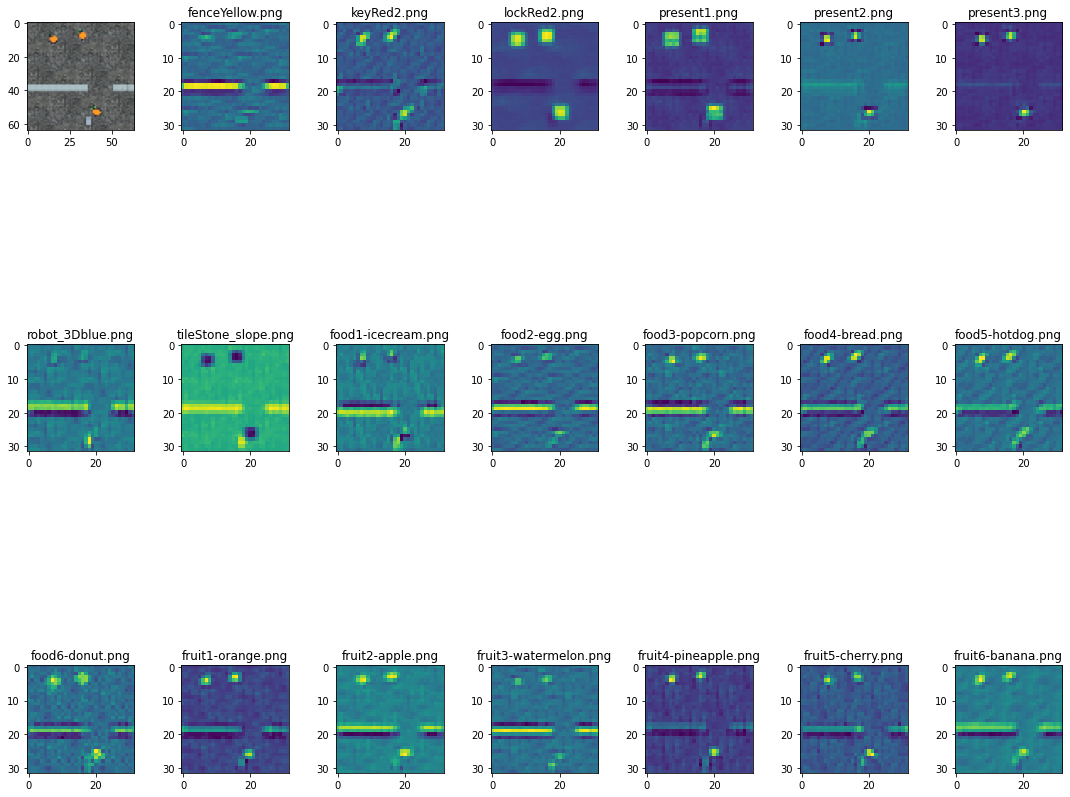

Error in callback <function flush_figures at 0x7f0ae2f8e4d0> (for post_execute):


KeyboardInterrupt: ignored

In [188]:
from time import time
from tqdm import tqdm
from functools import partial
tqm = partial(tqdm, position=0, leave=True)

env = ProcgenGym3Env(
    num=1, distribution_mode='easy', 
    env_name="fruitbot")

total_fps = 0

with tqdm(range(5000)) as trange:
    for step in trange:
        env.act(gym3.types_np.sample(env.ac_space, bshape=(env.num,)))
        rew, obs, first = env.observe()

        np.save( f'images/renders/image_{step}', obs['rgb'][0])

        t1 = time()
        filters, locs = template_match_torch(
            obs['rgb'][0].transpose(2, 0, 1)[np.newaxis, :, :, :], 
            templates, custom_conv
        )
        # obs_tensor = torch.from_numpy(np.array(obs['rgb']))
        # dist, out = m(obs_tensor)
        # filters, locs, names = template_match(obs['rgb'][0], templates)
        filters_shape = filters.shape
        t2 = time()
        
        # print(f"step {step} reward {rew} first {first}")
        step += 1
        total_fps += 1 / (t2 - t1)
        trange.set_description(
            f"FPS: {total_fps / step:.3f}.FShape: {filters.shape}. Obs Shape: {obs['rgb'][0].shape}""")

        if step % 10 == 0:
            fig, ax = plt.subplots(3, 7, figsize=(15, 15))
            # fig, ax = plt.subplots(1, 3, figsize=(15, 15))

            # ax[0].imshow(env.get_info()[0]['rgb'])
            # ax[0, 0].imshow(env.get_info()[0]['rgb'])
            ax[0, 0].imshow(obs['rgb'][0])
            for i, name in enumerate(names):
                i += 1
                ax[i // 7, i % 7].title.set_text(name)
                ax[i // 7, i % 7].imshow(filters[i - 1])

            # resize_fact = 8

            # ax[-1, -1].imshow(obs['rgb'][0])
            # ax[-1].imshow(locs)
            # ax[-2].imshow(obs['rgb'][0])
            # ax[-1].imshow(cv2.resize(
            #     env.get_info()[0]['rgb'],
            #     (64, 64),
            #     interpolation=cv2.INTER_CUBIC
            # ))
            fig.tight_layout()
            display.clear_output(wait=True)
            display.display(fig)

# Background Subtraction

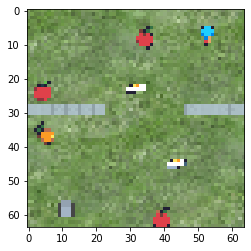

In [254]:
raw_image = np.load('./images/renders/image_3000.npy')
plt.imshow(raw_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


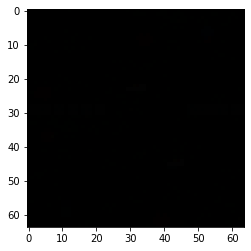

In [261]:
def normalize(img):
  normed_img = img / img.shape[-3] / img.shape[-2] / img.shape[-1]
plt.imshow(normalize(raw_image))

# Robust Template Matching using CNN

In [17]:
from torchvision import models, transforms, utils

In [18]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

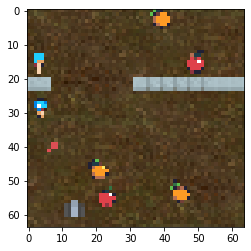

In [19]:
raw_image = np.load('./images/renders/image_99.npy')
plt.imshow(raw_image)

In [20]:
input_image = image_transform(raw_image.copy()).unsqueeze(0)
input_image.shape

torch.Size([1, 3, 64, 64])

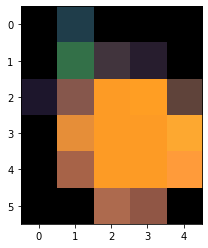

In [21]:
raw_template = templates['fruit1.png']['ds-img']
plt.imshow(raw_template)

In [22]:
input_template = image_transform(raw_template.copy()).unsqueeze(0)
input_template.shape

torch.Size([1, 3, 6, 5])

In [37]:
# vgg_feature = models.vgg11(pretrained=True).features
vgg_feature = models.vgg13(pretrained=True).features
# res18_feature = torch.nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])

In [38]:
from FeatureExtractor import FeatureExtractor

In [39]:
from time import time

t1 = time()
FE = FeatureExtractor(vgg_feature, use_cuda=False, padding=True)
boxes, centers, scores = FE(
    input_template, input_image, threshold=None, use_cython=False)
t2 = time()
1 / (t2 -t1)

save features...
calc NCC...
detected boxes: 2


5.324565490328502

In [206]:
def nms(dets, scores, thresh):
    x1 = dets[:, 0, 0]
    y1 = dets[:, 0, 1]
    x2 = dets[:, 1, 0]
    y2 = dets[:, 1, 1]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

d_img = raw_image.astype(np.uint8).copy()
nms_res = nms(np.array(boxes), np.array(scores), thresh=0.5)
print("detected objects: {}".format(len(nms_res)))
for i in nms_res:
    d_img = cv2.rectangle(d_img, boxes[i][0], boxes[i][1], (255, 0, 0), 1)
    # d_img = cv2.circle(d_img, centers[i], int(
    #     (boxes[i][1][0] - boxes[i][0][0])*0.2), (0, 0, 255), 1)

detected objects: 2


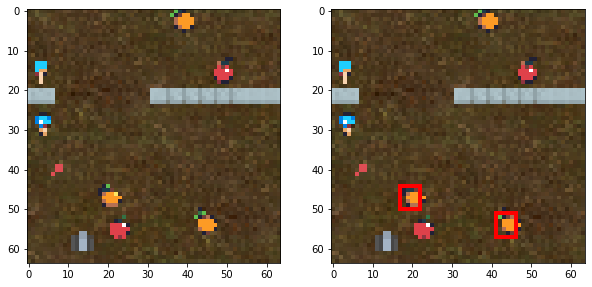

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(raw_image)
ax[1].imshow(d_img)
plt.show()